In [1]:
from __future__ import unicode_literals
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from helper_funcs import * 

import pandas as pd 
# prop = fm.FontProperties(fname='kalpurush ANSI.ttf')
# matplotlib.rcParams['font.family'] = prop.get_name()

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim

from numpy import linalg as LA

batch_size=128
random_state = 42 

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def print_accuracy(testloader, net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels, _ = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    print('Accuracy of the network on test images: %d %%' % (
        100 * correct / total))

In [4]:
def get_class_accuracies(net):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels, _ = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels.to(device)).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [5]:
def show_errors(testloader, net, n=10):
    count = 0
    ims = []
    preds = []
    actual = []
    with torch.no_grad():
        for data in testloader:
            images, labels, _ = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)            
            
            for (im, pred, label) in zip(images, predicted, labels):
                if pred.numpy() != label.numpy():
                    count += 1
                    ims.append(im.numpy())
                    preds.append(pred)
                    actual.append(label)
                    
                if count >= n: 
                    return ims, preds, actual 
                
    plot_gallery2(ims, preds, 2, 5)

In [6]:
transform=transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
])

trainset = BengaliDataset("data/train.csv","data/trainsplit", transform)
testset = BengaliDataset("data/test.csv","data/testsplit", transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

df = pd.read_csv("data/train.csv")
classes = list(range(df.label.max()+1))
n_classes = len(classes)

In [7]:
images, labels,t = next(iter(trainloader))
# images, labels,t = next(iter(testloader))

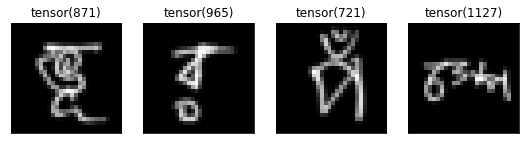

In [8]:
# show images
plot_gallery2(images,labels,1,4)

In [9]:
df.label.max()+1

1292

In [10]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Conv2d(1, 32, kernel_size=3, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*13*13, 100)
        self.fc2 = nn.Linear(100, n_classes)
        self.ReLU = nn.ReLU()
        
        self.last_hidden = None

    def forward(self, x):
        x = self.conv(x)
        x = self.ReLU(x)
        x = self.pool(x)
        x = x.view(-1, 32*13*13)
        x = self.ReLU(self.fc1(x))
        x = self.fc2(x)
        return x

    def get_last_hidden(self,x):
        x = self.pool(self.ReLU(self.conv(x)))
        x = x.view(-1, 32*13*13)
        x = self.ReLU(self.fc1(x))
        return x 
    
net = Net().to(device)
output = net(images.to(device))

In [11]:
output.shape

torch.Size([128, 1292])

In [12]:
# Training with MSE/Quadratic loss 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels, _ = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))        
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.004
[1,  1001] loss: 3.582
[2,     1] loss: 0.004
[2,  1001] loss: 3.582
[3,     1] loss: 0.004
[3,  1001] loss: 3.580
[4,     1] loss: 0.004
[4,  1001] loss: 3.579
[5,     1] loss: 0.004
[5,  1001] loss: 3.576
[6,     1] loss: 0.004
[6,  1001] loss: 3.573
[7,     1] loss: 0.004
[7,  1001] loss: 3.568
[8,     1] loss: 0.004
[8,  1001] loss: 3.560
[9,     1] loss: 0.004
[9,  1001] loss: 3.544
[10,     1] loss: 0.004
[10,  1001] loss: 3.513
[11,     1] loss: 0.004
[11,  1001] loss: 3.455
[12,     1] loss: 0.003
[12,  1001] loss: 3.354
[13,     1] loss: 0.003
[13,  1001] loss: 3.211
[14,     1] loss: 0.003
[14,  1001] loss: 3.072
[15,     1] loss: 0.003
[15,  1001] loss: 2.949
[16,     1] loss: 0.003
[16,  1001] loss: 2.845
[17,     1] loss: 0.003
[17,  1001] loss: 2.757
[18,     1] loss: 0.003
[18,  1001] loss: 2.683
[19,     1] loss: 0.002
[19,  1001] loss: 2.617
[20,     1] loss: 0.003
[20,  1001] loss: 2.560
Finished Training


In [14]:
# CrossEntropyLoss model 
print_accuracy(testloader, net)

# Get 10 test set errors 
# im, p, l = show_errors(testloader, net, n=10)
# plot_gallery2(im, p, 2, 5)

Accuracy of the network on test images: 7 %


In [ ]:
total = 0
correct = 0
with torch.no_grad():
    images, labels, _ = next(iter(testloader))
    outputs = net(images.to(device))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

In [ ]:
total, correct

In [23]:
import pandas as pd 
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

df = pd.read_csv("data/train.csv")

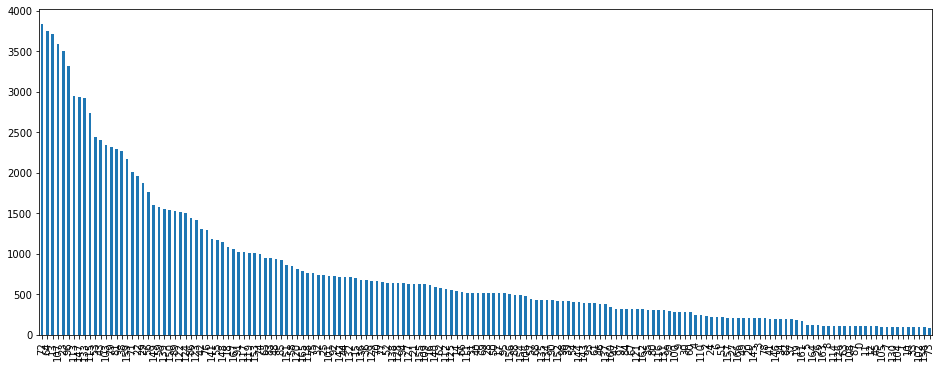

In [24]:
df['grapheme_root'].value_counts().plot.bar()

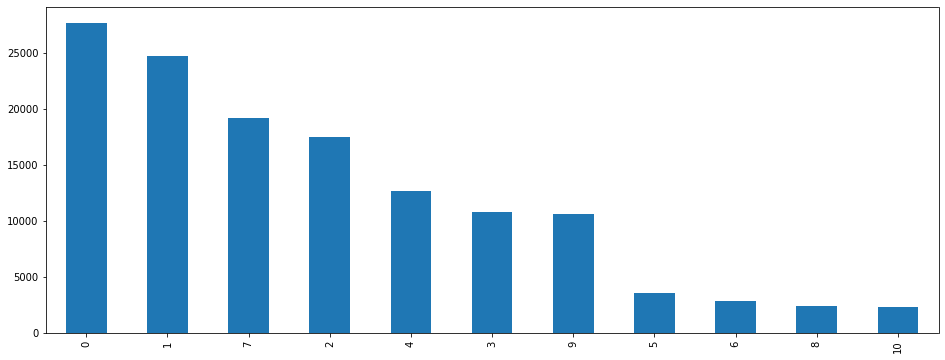

In [25]:
df['vowel_diacritic'].value_counts().plot.bar()


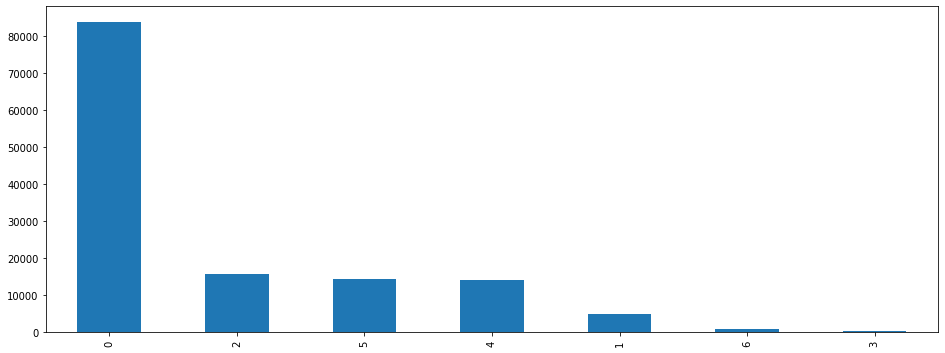

In [26]:
df['consonant_diacritic'].value_counts().plot.bar()


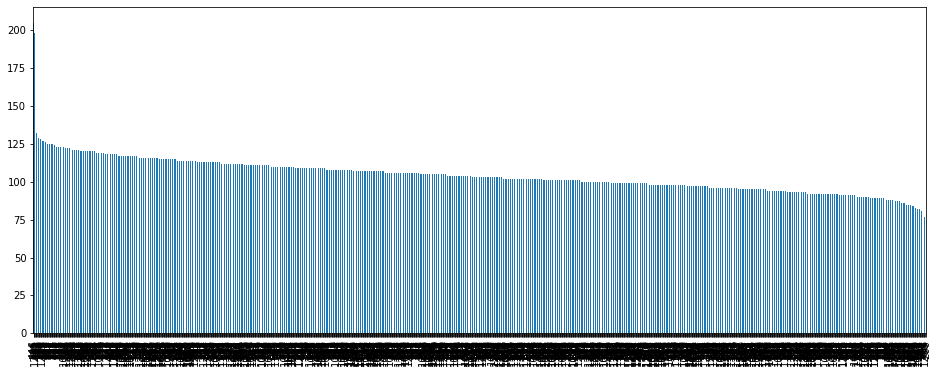

In [27]:
df['label'].value_counts().plot.bar()

In [28]:
tdf = pd.read_csv("data/test.csv")

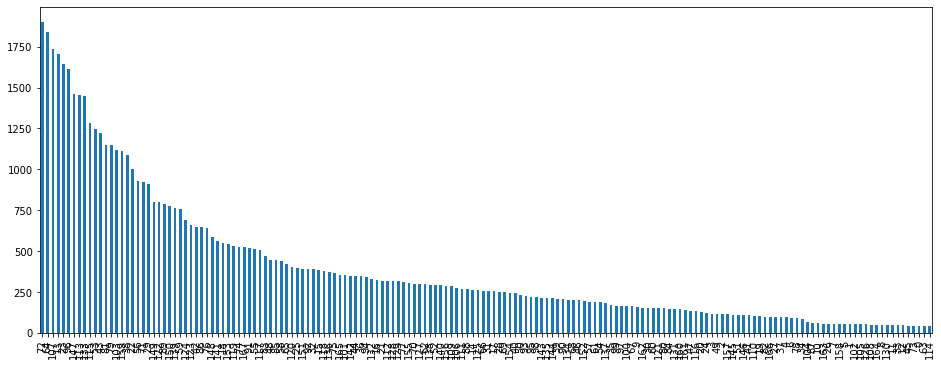

In [29]:
tdf['grapheme_root'].value_counts().plot.bar()

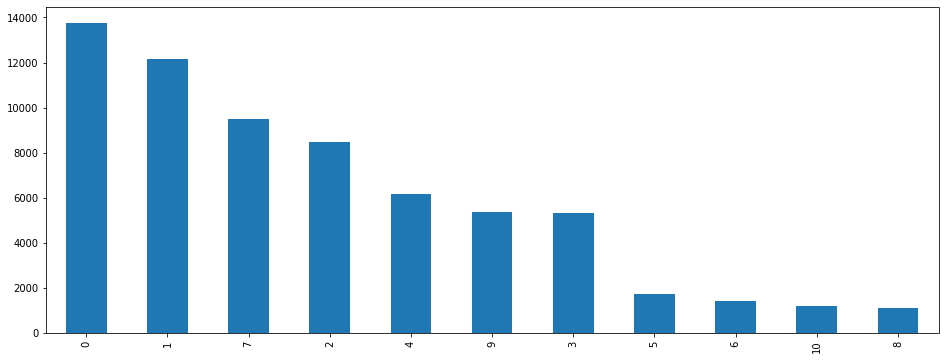

In [30]:
tdf['vowel_diacritic'].value_counts().plot.bar()

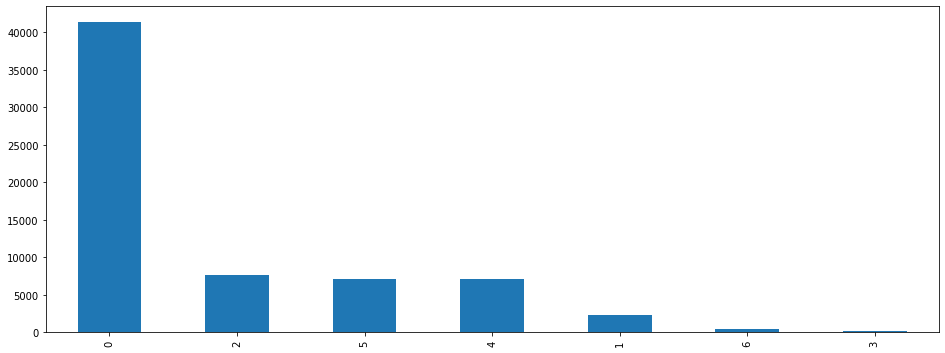

In [31]:
tdf['consonant_diacritic'].value_counts().plot.bar()

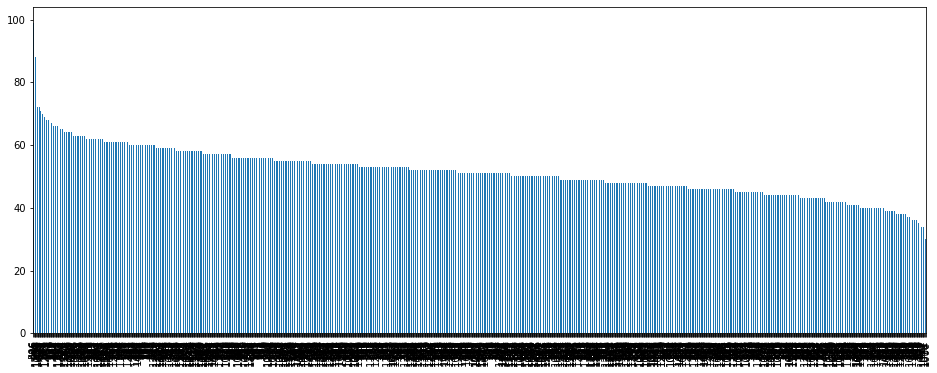

In [32]:
tdf['label'].value_counts().plot.bar()